<a href="https://colab.research.google.com/github/paulcodrea/reddit_humor/blob/main/2a_word_occurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM with a word ID embedding vector

This notebook creates, trains and evaluates an LSTM model to detect whether an input is a joke or not. It creates an embedding vector using the words' id in the corpus to represent each joke.

## Imports + Config

In [ ]:
import pandas as pd
import numpy as np
import pickle
import nltk
nltk.download('punkt')

from keras.models import Sequential
from keras.layers.core import Dense, Dropout 
from keras.layers import LSTM, Embedding

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\paulc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# We might have to change the following

config = {
    "learning_rate": 0.001,
    "epochs": 3, 
    "batch_size": 70,
    "train_p": 0.7,
    "test_p": 0.2,
    "val_p": 0.1,
    # "LSTM_layer": [50, 10],
    # "Dropout_layer": [0.5],
    # "activation": 'sigmoid',
    ##################### SAVE FOR LIVE DEMO #############################
    "model_path": './model/2a_model.h5',
    "tokenizer_path": './model/2a_tokenizer.pickle',
    "data_path": 'model/2a_data.csv',
}

## Methods

In [ ]:
class LSTM_model:
    def __init__(self, path):
        """
        Initializes the class.
        """
        self.path = path # Path to the dataset
        self.data = pd.DataFrame() # Dataframe to store the dataset

        self.vocabulary_size = 0
        self.tokenizer = Tokenizer(num_words=None, split=' ')

        self.jokes_to_numerical = []
        self.model = None


    def read_dataset(self):
        """
        Reads the dataset from the given path.
        """
        ret = pd.read_csv(self.path)
        ret.drop(columns=['Unnamed: 0'], inplace=True)

        count_zero = count_one = 0
        # check at which index the joke is 0 or 1
        for index, row in ret.iterrows():
            if row['funny'] == 0:
                count_zero += 1
            else:
                count_one += 1

        print("The input has {} jokes with 0 and {} jokes with 1".format(count_zero, count_one))

        self.data = ret


    def set_vocabulary_size(self, size):
        """
        Sets the vocabulary size.
        """
        self.vocabulary_size = size


    def convert_jokes_to_numerical(self, max_length):
        """
        Converts the jokes to numerical values and pads the vectors.
        """
        self.tokenizer.fit_on_texts(self.data['clean_text'].values) # fit the tokenizer
        self.jokes_to_numerical = self.tokenizer.texts_to_sequences(self.data['clean_text'].values) # convert jokes to numerical values
        self.jokes_to_numerical = pad_sequences(self.jokes_to_numerical, maxlen=max_length) # pad the sequences

        self.vocabulary_size = len(self.tokenizer.word_index) + 1 # +1 for the unknown token


    def split_dataset(self, X_dataset, y_dataset):
        """
        Splits the dataset into training and testing sets.
        """
        X = X_dataset
        y = y_dataset

        # convert X as a numpy array float32
        X = np.array(X, dtype=np.float32)
        y = np.array(y, dtype=np.float32)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config['test_p'], 
                                                            random_state=42)

        return X_train, X_test, y_train, y_test


    def LSTM_model(self, max_length):
        """
        Splits the data into train and validation sets.
        Constructs the LSTM model.
        """
        X_train, X_test, y_train, y_test = self.split_dataset(X_dataset=self.jokes_to_numerical, 
                                                              y_dataset=self.data['funny'])

        # define the model
        self.model = Sequential()
        self.model.add(Embedding(input_dim=self.vocabulary_size, output_dim=max_length, 
                                 input_length=int(X_train.shape[1])))
        self.model.add(LSTM(units=50, return_sequences=True))
        self.model.add(LSTM(units=10))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(units=1, activation='sigmoid'))
        self.model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.model.summary()
        self.model.fit(X_train, y_train, epochs=config['epochs'], batch_size=config['batch_size'], 
                       verbose='auto', validation_split=config['val_p'])

        self.evaluate_model(X_test, y_test, max_length) # evaluate the model


    def evaluate_model(self, X_test, y_test, max_length):
        """
        Evaluates the model.
        """
        scores = self.model.evaluate(X_test, y_test)
        print("Accuracy: %.2f%%" % (scores[1] * 100))

        y_pred = self.model.predict(X_test)
        y_pred = np.round(y_pred)

        # create precision, recall, f1 manually
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print("Precision: %.2f%%" % (precision * 100))
        print("Recall: %.2f%%" % (recall * 100))
        print("F1-Score: %.2f%%" % (f1 * 100))


        ##################################### PLOTTING #####################################
        # Binary classification plotting 
        # Plotting the confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10,10))
        sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square=True, cmap='Blues_r')
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.title('Confusion Matrix')
        plt.show()


        # plot how many jokes are predicted as funny
        plt.figure(figsize=(10,10))
        sns.set(font_scale=1.4)
        sns.set_style("whitegrid")
        sns.distplot(y_test, kde=False, bins=10, label='Actual')
        sns.distplot(y_pred, kde=False, bins=10, label='Predicted')
        plt.legend()
        plt.title('Binary Classification Accuracy')
        plt.show()
        ######################################################################################

        # Save data
        self.save_data(max_length, scores[1], precision, recall, f1)

    def save_data(self, max_length, accuracy, precision, recall, f1):
        """
        Saves the data.
        """
        # Add in dataframe master_df max_len, accuracy, precision, recall, f1-score
        ret = pd.DataFrame(columns=['max_len', 'accuracy', 'precision', 'recall', 'f1-score'])
        ret.loc[0] = [max_length, accuracy, precision, recall, f1]
        ret.to_csv(config['data_path'])
        
        self.model.save(config['model_path']) # save the model

        # save the tokenizer
        with open(config['tokenizer_path'], 'wb') as handle:
            pickle.dump(self.tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Read data and process it.

In [ ]:
# SETTINGS for local machine - change this for Goolg Colab

path = "dataset/1a_final_jokes(2918).csv" # DATASET 1a
# path = "dataset/1b_final_jokes(2826)(stopwords)(uppercase).csv" # DATASET 1b
# path = "dataset/2a_final_jokes_and_facts(2918).csv" # DATASET 2a
# path = "dataset/2b_final_jokes_and_facts(2826)(stopwords)(uppercase).csv" # DATASET 2b


joke_model = LSTM_model(path)
joke_model.read_dataset()

max_length_joke = joke_model.data['token_count'].max()
joke_model.convert_jokes_to_numerical(max_length_joke) # convert the jokes to numerical values

print("Max length of joke: ", max_length_joke)
print("Vocabulary size: ", joke_model.vocabulary_size)

The input has 1413 jokes with 0 and 1413 jokes with 1
Max length of joke:  196
Vocabulary size:  9144


### Train the model & Save the model (for live demo)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 196, 196)          1792224   
                                                                 
 lstm_6 (LSTM)               (None, 196, 50)           49400     
                                                                 
 lstm_7 (LSTM)               (None, 10)                2440      
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,844,075
Trainable params: 1,844,075
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
30/30 [===========================

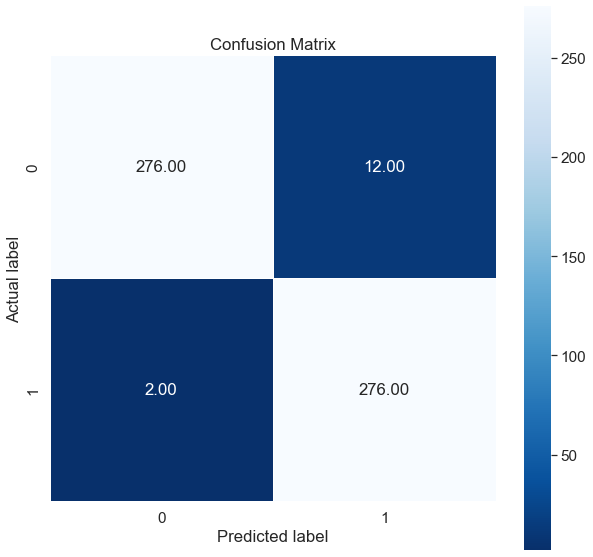

c:\Users\paulc\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


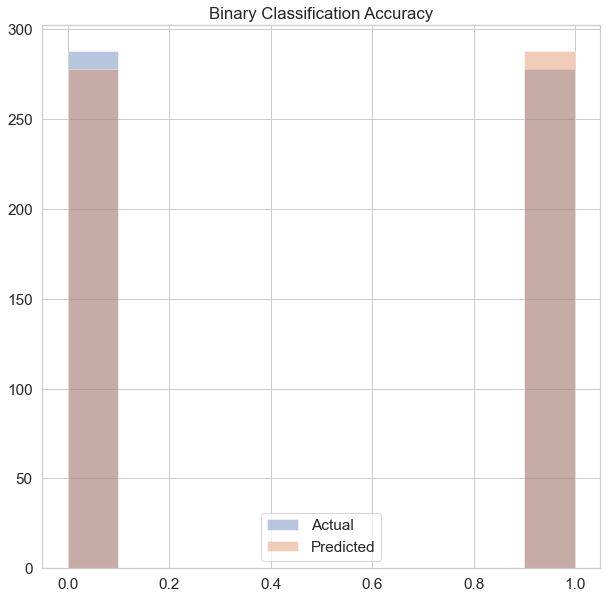

In [ ]:
joke_model.LSTM_model(max_length_joke)